### 1) Making plot of domain and bathymetry

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
cascadiafile = '/home/ssahu/saurav/NEMO_run/bathy_casacadia/cascadia.bil'
def getcascadia(filename):
    # Adapted from: https://pymorton.wordpress.com/2016/02/26/plotting-prism-bil-arrays-without-using-gdal/
    def read_prism_hdr(hdr_path):
        """Read an ESRI BIL HDR file"""
        with open(hdr_path, 'r') as input_f:
            header_list = input_f.readlines()
        return dict(item.strip().split() for item in header_list)
    def read_prism_bil(bil_path):
        """Read an array from ESRI BIL raster file"""
        hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
        data = np.fromfile(bil_path, dtype=np.int16).byteswap()
        data = data.reshape(int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
        return data
    z = np.flipud(read_prism_bil(filename))    # load data
    mask = (z == 0) | (z >= 10000)             # mask for nonexistant points and land points
    z -= 10000                                 # remove offset
    z *= -1                                    # make depths positive
    z[mask] = 0                                # set masked values to zero
    zm = ma.masked_array(z, mask=mask)
    # Construct Cascadia coordinates
    xmin, xmax, dx = -738044.062, 749705.938, 250
    ymin, ymax, dy = 101590.289, 1710340.289, 250
    x=xmin + dx*np.arange(0, z.shape[1]) + dx/2
    y=ymin + dy*np.arange(0, z.shape[0]) + dy/2
    p = Proj(r'+proj=lcc +lat_1=41.5 +lat_2=50.5 +lat_0=38 +lon_0=-124.5 +x_0=0 +y_0=0 +ellps=clrk66 +no_defs')
    lat_min, lat_max=47, 50
    lon_min, lon_max=123, 130
    lat=np.linspace(lat_min,lat_max,660)
    lon=np.linspace(lon_min,lon_max,1144)
    grid=np.meshgrid(lat,lon)
    return x,y,z,p

def Colormap():
    COLORMAP = """\
    # downloaded from IBCAO homepage
    #Discrete color table for Ocean and continous for land in RGB for the Arctic bathymetry and topography
    -6000	18	10	59	-5000	18	10	59
    -5000	22	44	103	-4000	22	44	103
    -4000	22	88	135	-3000	22	88	135
    -3000	22	138	170	-2000	22	138	170
    -2000	22	154	184	-1500	22	154	184
    -1500	23	170	198	-1000	23	170	198
    -1000	23	186	212	-500	23	186	212
    -500	24	196	223	-250	24	196	223
    -250	25	206	234	-100	25	206	234
    -100	27	216	245	-75	27	216	245
    -75	38	223	241	-50	38	223	241
    -50	49	230	236	-25	49	230	236
    -25	105	242	233	-10	105	242	233
    -10	161	255	230	0	161	255	230
    0	40	158	38	25	44	176	42
    25	44	176	42	50	49	195	46
    50	49	195	46	75	145	208	80
    75	145	208	80	100	242	202	90
    100	242	202	90	200	227	170	48
    200	227	170	48	300	190	140	40
    300	190	140	40	400	151	109	31
    400	151	109	31	500	114	80	23
    500	114	80	23	600	95	63	12
    600	95	63	12	700	81	57	16
    700	81	57	16	800	114	97	71
    800	114	97	71	1000	105	105	105
    1000	105	105	105	1500	170	170	170
    1500	170	170	170	5000	200	200	200
    """
    cmap = np.empty ((0,4))
    c = 0
    for l in COLORMAP.split("\n"):
      l = l.strip()
      if len(l) == 0 or l[0] == '#':
        continue
      ls = np.array([float (v) for v in l.split ()])
      if ls.shape[0] < 8:
        continue
      c += 1
      cmap.resize (c, 4)
      cmap[c-1,:] = ls[:4]
    c += 1
    cmap.resize (c, 4)
    cmap[c-1,:] = ls[4:]
    cmap[:,[1, 2, 3]] = cmap[:,[1, 2, 3]] / 255.
    cmap_out = cm.colors.ListedColormap (cmap[:,1:4], 'ibcao', c)
    norm     = cm.colors.BoundaryNorm (cmap[:,0], c)
    return (cmap_out, norm)

(cmapmc, norm) = Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[0::])

In [ ]:
x,y,z,p = getcascadia(cascadiafile)

In [3]:
def def_region(xl=-400e3, xr=60e3, yb=800e3, yt=1600e3):
    ''' Returns an extract of the complete IBCAO bathymetric
    grid using xl, xr, yb, and yt, which correpond to the left,
    right, bottom, and top boundaries when plotted.
    '''

    x,y,z,p = getcascadia(cascadiafile)

    xmin = np.where(x<xl)[0][-1]
    xmax = np.where(x>xr)[0][0]
    ymin = np.where(y>yb)[0][0]
    ymax = np.where(y<yt)[0][-1]
    x_region = x[xmin:xmax]
    y_region = y[ymin:ymax]
    z_region = z[ymin:ymax, xmin:xmax]
    return x_region, y_region, z_region

x_region, y_region, z_region = def_region()

vmin, vmax =  z_region.min(), 500



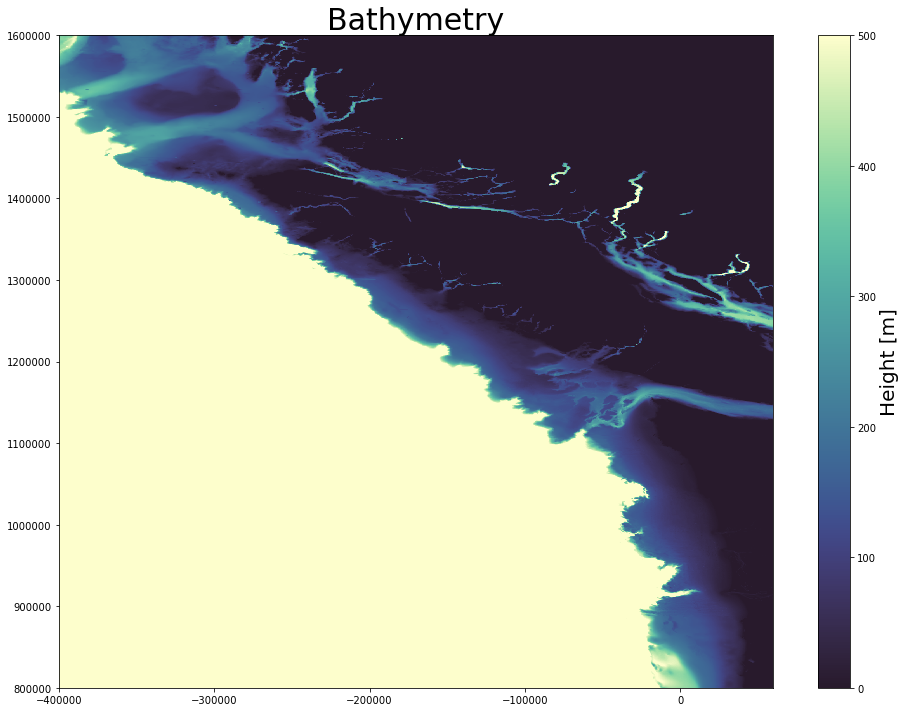

In [4]:
ysize=15
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(x_region, y_region, z_region, cmap=cmo.cm.deep_r, vmin=vmin, vmax=vmax)
n=6
# ax.scatter(lon_s_grid[::n,::n], lat_s_grid[::n,::n], c='orangered', s=30, alpha=0.6, vmin=vmin, vmax=vmax)
ax.set_xlim([x_region.min(), x_region.max()])
ax.set_ylim([y_region.min(), y_region.max()])
ax.set_title('Bathymetry', fontsize=30)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Height [m]', fontsize=20)
# plt.savefig('domain.png')

### 2) Plot the bathymetry from bathy_meter.nc and the co-ordinate points

In [3]:
bathy = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc')

Z = bathy.variables['Bathymetry'][:]

In [4]:
Z.shape

(390, 290)

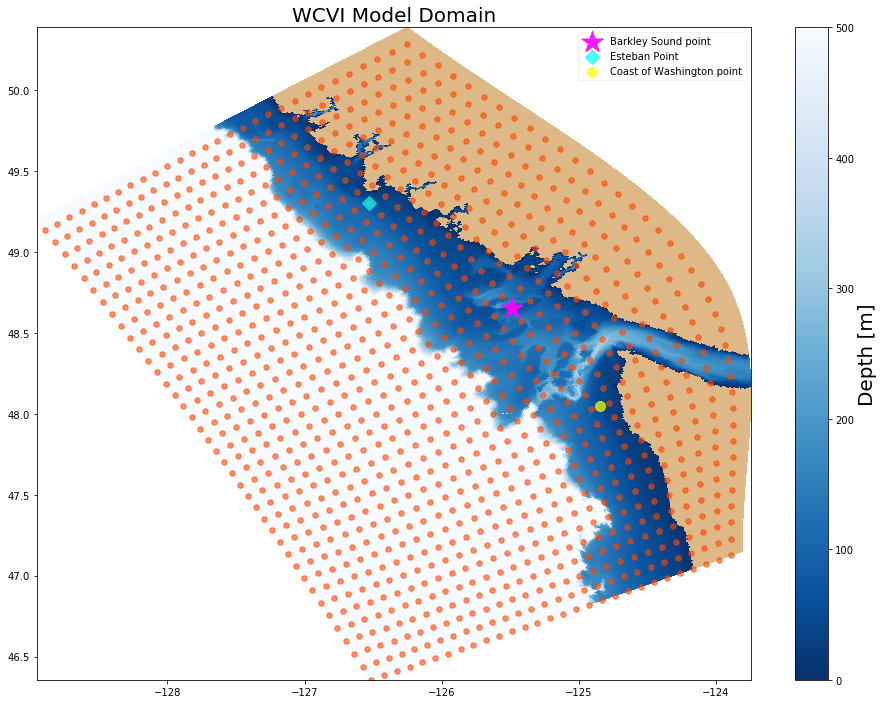

In [5]:
grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Blues_r')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(lon, lat, z0, cmap=cmap, vmin=0, vmax=500)
n=10
ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
ax.scatter(lon[200,200], lat[200,200], c='magenta', s=500, alpha=0.9, marker='*', label = 'Barkley Sound point')
ax.scatter(lon[300,180], lat[300,180], c='cyan', s=100, alpha=0.7, marker='D', label = 'Esteban Point')
ax.scatter(lon[120,215], lat[120,215], c='yellow', s=100, alpha=0.7, marker='o', label = 'Coast of Washington point')
ax.set_xlim([lon.min(), lon.max()])
ax.set_ylim([lat.min(), lat.max()])
ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
# plt.savefig('domain.png')

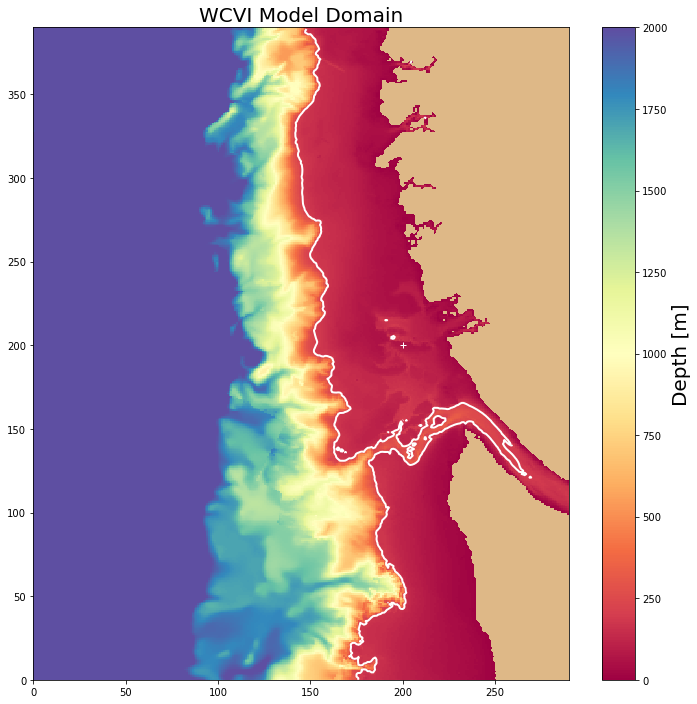

In [20]:
grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Spectral')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,12)); ax.grid()
p = ax.pcolormesh(z0, cmap=cmap, vmin=0)#, vmax=500)
n=10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.set_xlim([lon.min(), lon.max()])
# ax.set_ylim([lat.min(), lat.max()])



ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
CS = ax.contour(z0, levels = [200], colors=('white',),linestyles=('-',),linewidths=(2,))
ax.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',)
# plt.savefig('domain.png')

NameError: name 'x_slice' is not defined

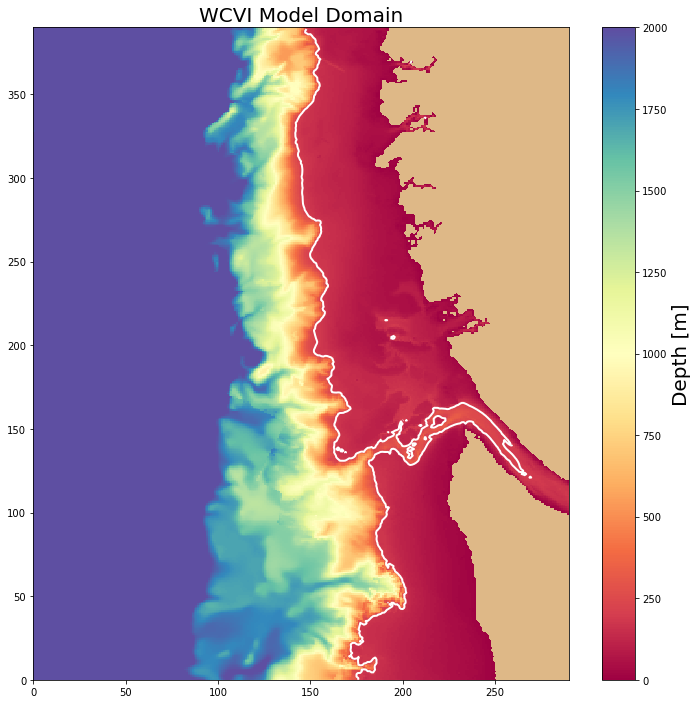

In [6]:
grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Spectral')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,12)); ax.grid()
p = ax.pcolormesh(z0, cmap=cmap, vmin=0)#, vmax=500)
n=10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.set_xlim([lon.min(), lon.max()])
# ax.set_ylim([lat.min(), lat.max()])



ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
CS = ax.contour(z0, levels = [200], colors=('white',),linestyles=('-',),linewidths=(2,))
ax.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',)
# plt.savefig('domain.png')

In [ ]:
### 2) Making no Canyon bathymetry

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [52]:
bathy = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc')

Z = bathy.variables['Bathymetry'][:]
lon = bathy.variables['nav_lon'][:]
lat = bathy.variables['nav_lat'][:]

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


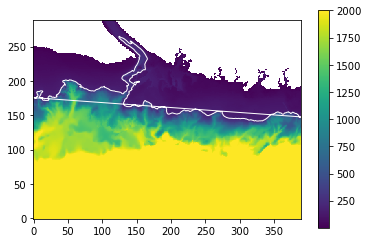

In [46]:
from matplotlib import pyplot as plt
from matplotlib import _cntr as cntr

z= Z

x, y = np.mgrid[:z.shape[0], :z.shape[1]]
# x, y = np.meshgrid(z.shape[0],z.shape[1])
c = cntr.Cntr(x, y, z)

# trace a contour at z == 0.5
res = c.trace(200)

# result is a list of arrays of vertices and path codes
# (see docs for matplotlib.path.Path)
nseg = len(res) // 2
segments, codes = res[:nseg], res[nseg:]

fig, ax = plt.subplots(1, 1)
img = ax.imshow(z.T, origin='lower')
plt.colorbar(img)
ax.hold(True)
p = plt.Polygon(segments[0], fill=False, color='w')
ax.add_artist(p)
plt.show()

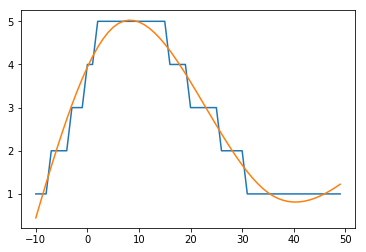

In [5]:
import numpy as np
import matplotlib.pyplot as plt


list_x = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
list_y = [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


from scipy.interpolate import splrep, splev

plt.figure()
bspl = splrep(list_x,list_y,s=5)
bspl_y = splev(list_x,bspl)
plt.plot(list_x,list_y)
plt.plot(list_x,bspl_y)
plt.show()

In [6]:
import numpy as np
import cv2 as cv
img = cv.imread('domain.png',0)
ret,thresh = cv.threshold(img,127,255,0)
im2,contours,hierarchy = cv.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv.moments(cnt)
print( M )

{'m21': 1438505530.0, 'nu20': 0.1388888888888889, 'm20': 1868189.0, 'mu03': 4.76837158203125e-07, 'm30': 1042455042.0, 'mu12': 8.66129994392395e-08, 'm01': 4620.0, 'mu11': 0.0, 'nu11': 0.0, 'nu12': 9.822113598060292e-10, 'm12': 1985030130.0, 'mu21': 0.0, 'm03': 2739201850.0, 'm11': 2577960.0, 'nu30': 0.0, 'm10': 3348.0, 'mu02': 1.6666666665114462, 'nu02': 0.04629629629198462, 'nu21': 0.0, 'nu03': 5.407443185168677e-09, 'mu30': 0.0, 'm00': 6.0, 'mu20': 5.0, 'm02': 3557401.6666666665}


In [9]:
hull = cv.convexHull(cnt)

In [10]:
k = cv.isContourConvex(cnt)

In [42]:
from salishsea_tools import bathy_tools

In [49]:
depth_diff = bathy_tools.calc_norm_depth_diffs(Z, 1, 1)

In [50]:
depth_diff.shape

(389, 289)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import cmocean.cm as cm 
from IPython.display import display, Math, Latex
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline

In [12]:
u_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_U.nc')
v_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_V.nc')



bathy = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc').variables['Bathymetry'][:]



ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']

zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']
lat = u_vel.variables['nav_lat']
lon = u_vel.variables['nav_lon']

In [9]:
ugrid.shape

(683, 40, 390, 290)

OSError: No such file or directory

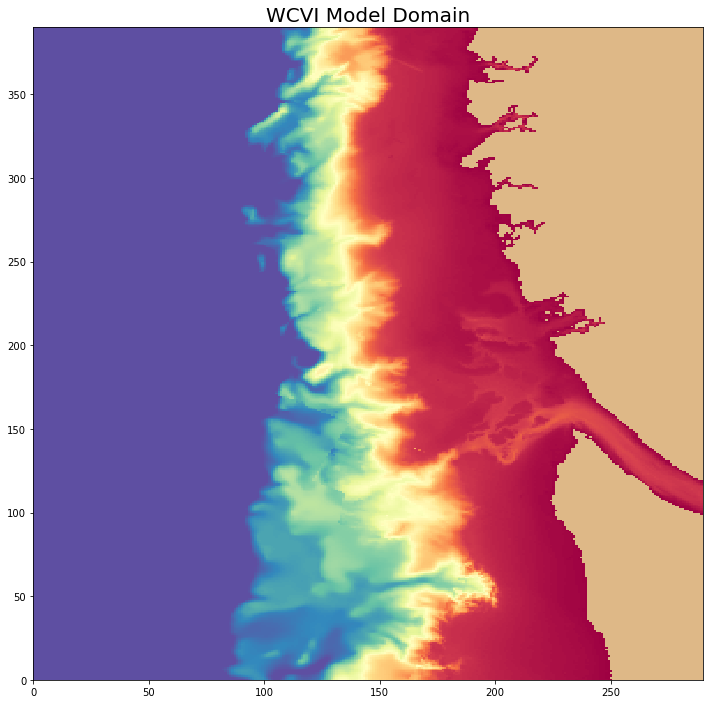

In [45]:
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo

grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')

lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Spectral')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,12)); ax.grid()
p = ax.pcolormesh(z0, cmap=cmap, vmin=0)#, vmax=500)
n=10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.set_xlim([lon.min(), lon.max()])
# ax.set_ylim([lat.min(), lat.max()])



ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
CS = ax.contour(z0, levels = [200], colors=('white',),linestyles=('-',),linewidths=(2,))
ax.plot(
    x_slice[185], y_slice[185],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',)
# plt.savefig('domain.png')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


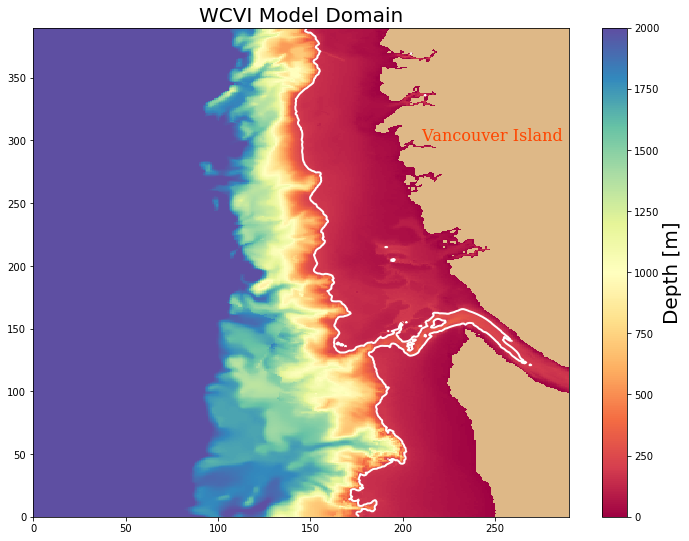

In [51]:
grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')

x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])


lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Spectral')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,9)); ax.grid()
p = ax.pcolormesh(z0, cmap=cmap, vmin=0)#, vmax=500)
n=10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.set_xlim([lon.min(), lon.max()])
# ax.set_ylim([lat.min(), lat.max()])



ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc', color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
font = {'family': 'serif',
        'color':  'orangered',
        'weight': 'normal',
        'size': 16,
        }
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
CS = ax.contour(z0, levels = [200], colors=('white',),linestyles=('-',),linewidths=(2,), label='200m isobath')
plt.text(210, 300, r'Vancouver Island', fontdict=font)
# ax.plot(
#     x_slice[185], y_slice[185],
#     linestyle='-', marker='+', color='white',
#     label='Barkeley Sound Point',)
# ax.plot(
#     x_slice[185], y_slice[185],
#     linestyle='-', marker='+', color='white',
#     label='Barkeley Sound Point',)

legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
# plt.savefig('domain.png')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


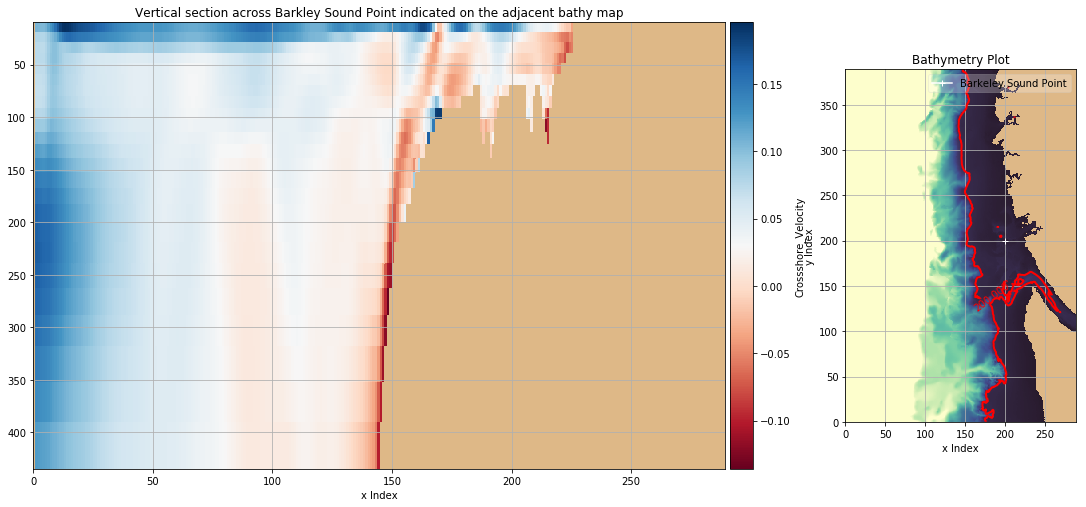

In [10]:
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])


# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

u_0 = ugrid[t, :, :,:]
u_masked = np.ma.masked_values(u_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)

x, z = np.meshgrid(x_slice, zlevels[:25])
mesh = axl.pcolormesh(x_slice, zlevels[:25], u_masked[:25,200,x_slice], cmap=cmap)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Crossshore_Velocity')
clines = axl.contour(x_slice, zlevels[:25], u_masked[:25,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


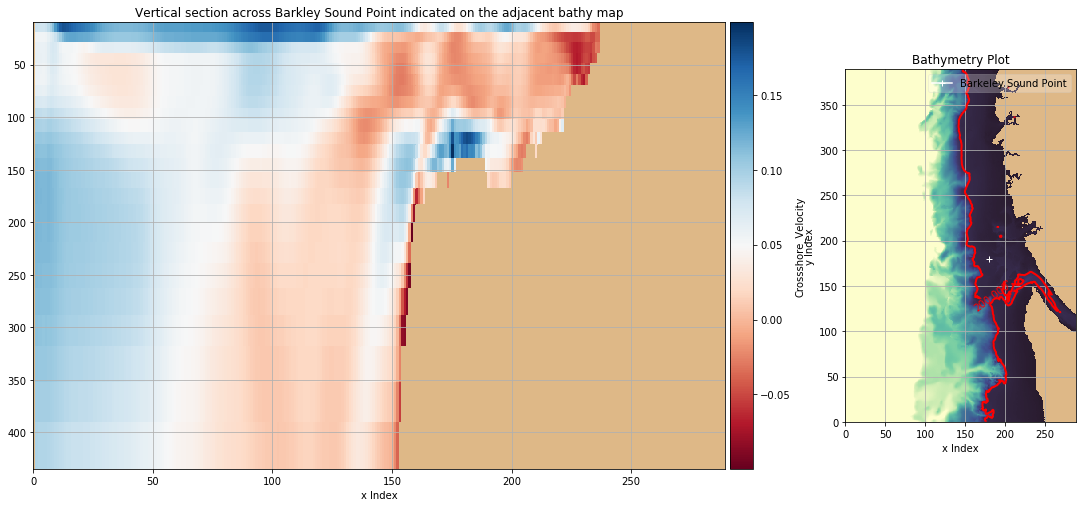

In [39]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[180],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

u_0 = ugrid[t, :, :,:]
u_masked = np.ma.masked_values(u_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)

x, z = np.meshgrid(x_slice, zlevels[:25])
mesh = axl.pcolormesh(x_slice, zlevels[:25], u_masked[:25,180,x_slice], cmap=cmap)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Crossshore_Velocity')
clines = axl.contour(x_slice, zlevels[:25], u_masked[:25,180,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


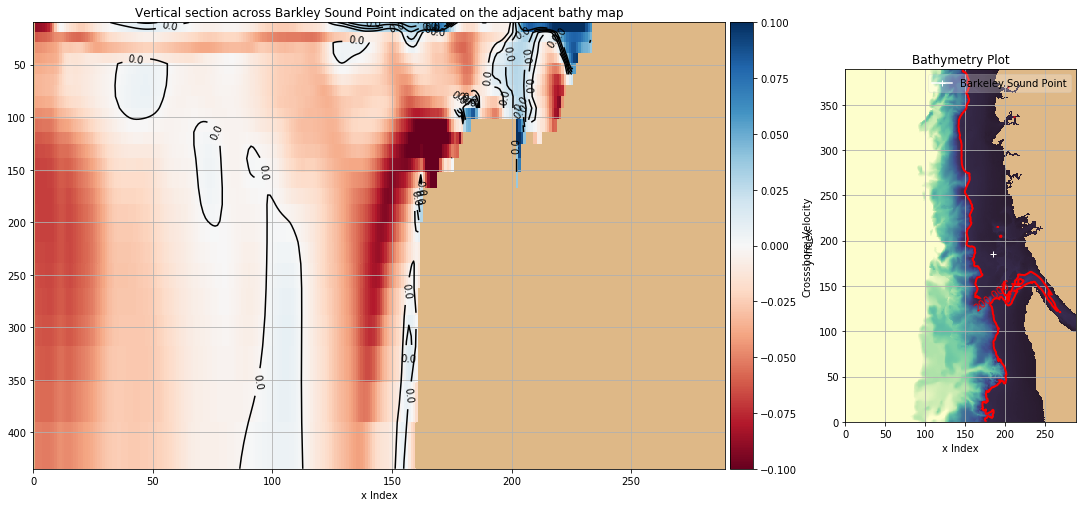

In [50]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[185], y_slice[185],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)

x, z = np.meshgrid(x_slice, zlevels[:25])
mesh = axl.pcolormesh(x_slice, zlevels[:25], v_masked[:25,185,x_slice], cmap=cmap, vmin = -0.1, vmax = 0.1)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Crossshore_Velocity')
clines = axl.contour(x_slice, zlevels[:25], v_masked[:25,185,x_slice], np.arange(0, 0.05, 0.01), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

In [46]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


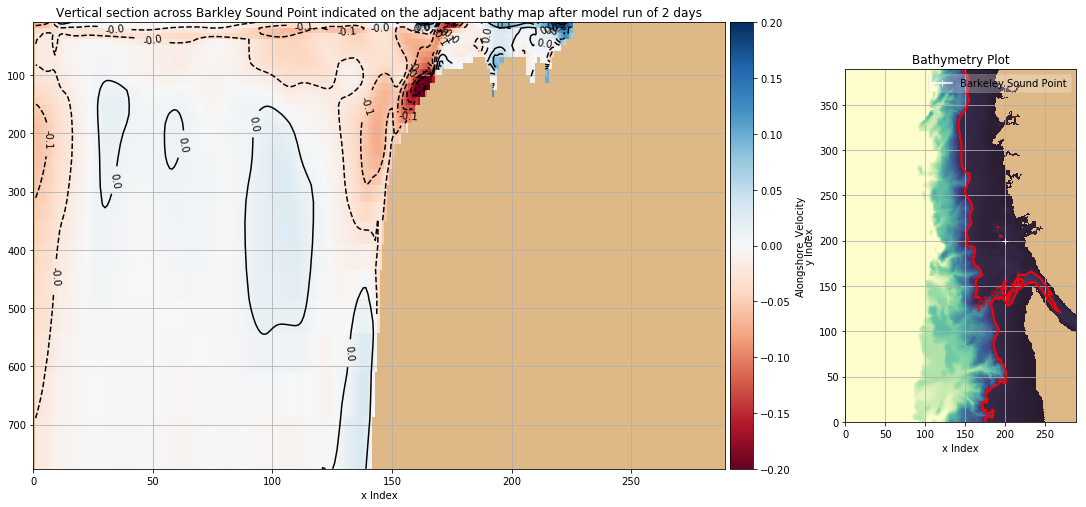

In [35]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,200,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,200,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 2 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


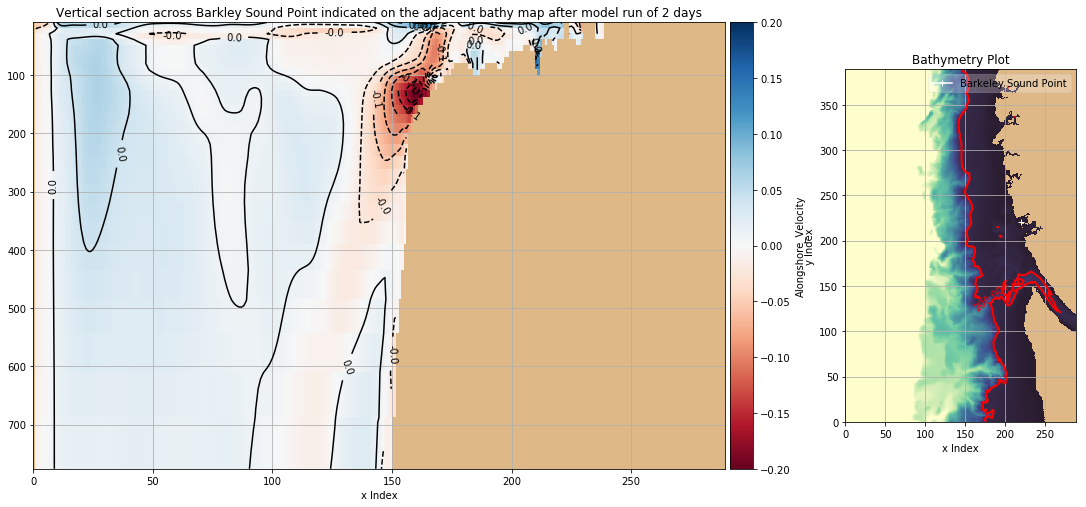

In [33]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[220], y_slice[220],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,220,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,220,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 2 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


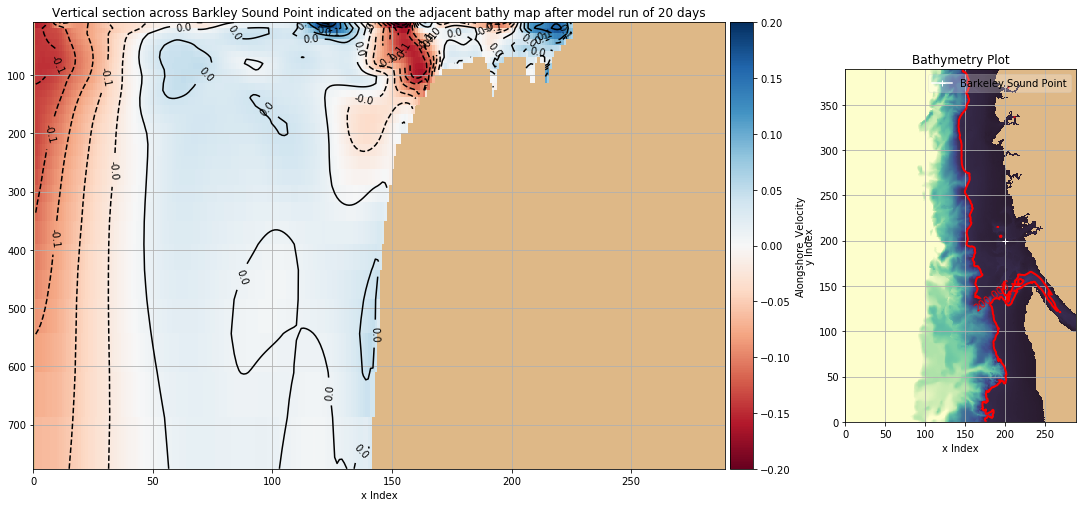

In [36]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 479

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,200,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,200,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 20 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


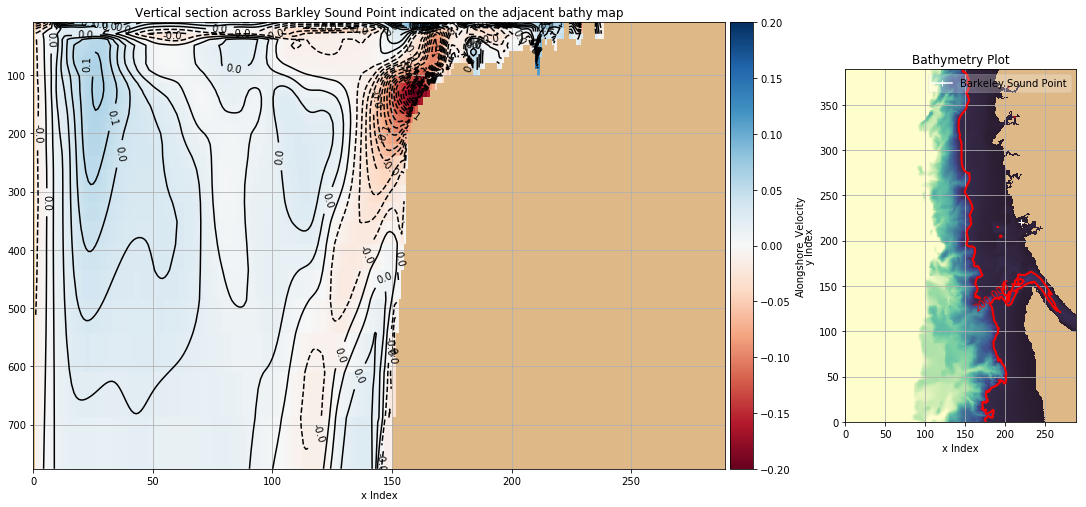

In [35]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
bathymetry = bathy
x_slice = np.arange(bathy.shape[1])
y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[220], y_slice[220],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,220,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,220,x_slice], np.arange(-0.2, 0.2, 0.01), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

In [10]:
tracers = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_T.nc')

bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'

ssh = tracers.variables['sossheig']
lats = tracers.variables['nav_lat']
lons = tracers.variables['nav_lon']
sal = tracers.variables['vosaline']

In [19]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=32,vmax=34)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


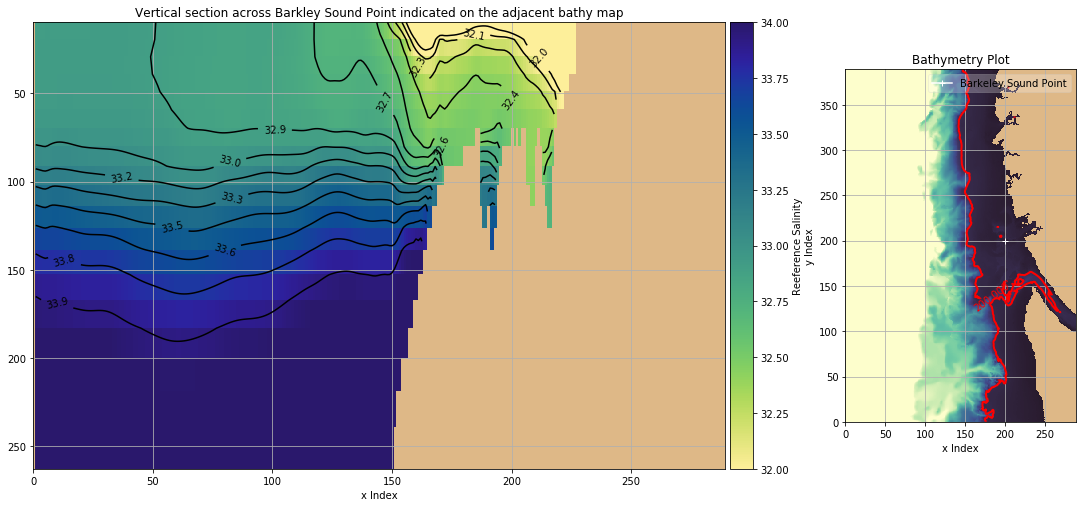

In [20]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

In [21]:
atmos_forcing_file = nc.Dataset('/ocean/ssahu/CANYONS/nemo-forcing/43_days_JP_primitive/ops_y2016m04d03.nc')
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



u_wind = atmos_forcing_file.variables['u_wind']
v_wind = atmos_forcing_file.variables['v_wind']
timesteps =u_wind.shape[0]

bathy_file = nc.Dataset(bathy)

lon = bathy_file.variables['nav_lon'][:]
lat = bathy_file.variables['nav_lat'][:]


X = lon.flatten()
Y = lat.flatten()

points = (X[:],Y[:])

big_lon_atmos = atmos_forcing_file.variables['nav_lon'][:]

big_lon = np.empty_like(big_lon_atmos)
big_lon[:] = big_lon_atmos[:] - 360

big_lat = atmos_forcing_file.variables['nav_lat'][:]

X_big = big_lon.flatten()
Y_big = big_lat.flatten()

xi = (X_big[:],Y_big[:])

interp_wind_u = np.empty((u_wind.shape[0], lon.shape[0], lon.shape[1]))
interp_wind_v = np.empty_like(interp_wind_u)

for i in np.arange(u_wind.shape[0]):
    interp_wind_u[i,...] = np.reshape(griddata(xi, u_wind[i,...].flatten(), points, method= 'linear'), lon.shape)
    interp_wind_v[i,...] = np.reshape(griddata(xi, v_wind[i,...].flatten(), points, method= 'linear'), lon.shape)




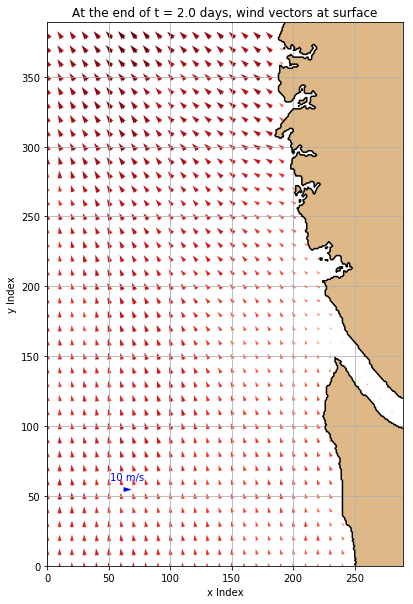

In [28]:
y_slice = np.arange(lat.shape[0])
x_slice = np.arange(lat.shape[1])
t = 23




u_tzyx_wind, v_tzyx_wind = viz_tools.unstagger(interp_wind_u[t,...], interp_wind_v[t,...])
speeds_wind = np.sqrt(np.square(u_tzyx_wind) + np.square(v_tzyx_wind))


arrow_step = 10
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
X,Y = np.meshgrid(x_slice_a,y_slice_a)


# Plot the velocity vectors

# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(X, Y, u_tzyx_wind[::arrow_step,::arrow_step], v_tzyx_wind[::arrow_step,::arrow_step], speeds_wind[::arrow_step,::arrow_step] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy)


ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, wind vectors at surface'.format((t+1+24)/24))
ax.quiverkey(quiver, 65, 55, 10, '10 m/s', coordinates='data', color='blue', labelcolor='blue')


In [41]:
atmos_forcing_file = nc.Dataset('/ocean/ssahu/CANYONS/nemo-forcing/43_days_JP_primitive/ops_y2016m04d19.nc')
bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



u_wind = atmos_forcing_file.variables['u_wind']
v_wind = atmos_forcing_file.variables['v_wind']
timesteps =u_wind.shape[0]

bathy_file = nc.Dataset(bathy)

lon = bathy_file.variables['nav_lon'][:]
lat = bathy_file.variables['nav_lat'][:]


X = lon.flatten()
Y = lat.flatten()

points = (X[:],Y[:])

big_lon_atmos = atmos_forcing_file.variables['nav_lon'][:]

big_lon = np.empty_like(big_lon_atmos)
big_lon[:] = big_lon_atmos[:] - 360

big_lat = atmos_forcing_file.variables['nav_lat'][:]

X_big = big_lon.flatten()
Y_big = big_lat.flatten()

xi = (X_big[:],Y_big[:])

interp_wind_u = np.empty((u_wind.shape[0], lon.shape[0], lon.shape[1]))
interp_wind_v = np.empty_like(interp_wind_u)

for i in np.arange(u_wind.shape[0]):
    interp_wind_u[i,...] = np.reshape(griddata(xi, u_wind[i,...].flatten(), points, method= 'linear'), lon.shape)
    interp_wind_v[i,...] = np.reshape(griddata(xi, v_wind[i,...].flatten(), points, method= 'linear'), lon.shape)




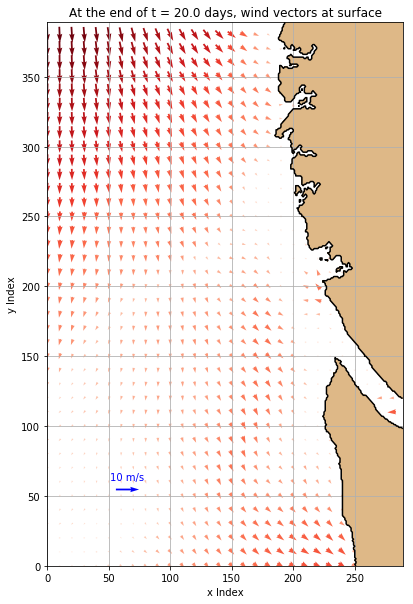

In [44]:
y_slice = np.arange(lat.shape[0])
x_slice = np.arange(lat.shape[1])
t = 23

bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'



u_tzyx_wind, v_tzyx_wind = viz_tools.unstagger(interp_wind_u[t,...], interp_wind_v[t,...])
speeds_wind = np.sqrt(np.square(u_tzyx_wind) + np.square(v_tzyx_wind))


arrow_step = 10
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
X,Y = np.meshgrid(x_slice_a,y_slice_a)


# Plot the velocity vectors

# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
quiver = ax.quiver(X, Y, u_tzyx_wind[::arrow_step,::arrow_step], v_tzyx_wind[::arrow_step,::arrow_step], speeds_wind[::arrow_step,::arrow_step] ,pivot='mid', cmap='Reds', width=0.005)
viz_tools.plot_land_mask(ax, bathy , xslice=x_slice, yslice=y_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy)


ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('At the end of t = {0} days, wind vectors at surface'.format((t+1+24*19)/24))
ax.quiverkey(quiver, 65, 55, 10, '10 m/s', coordinates='data', color='blue', labelcolor='blue')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


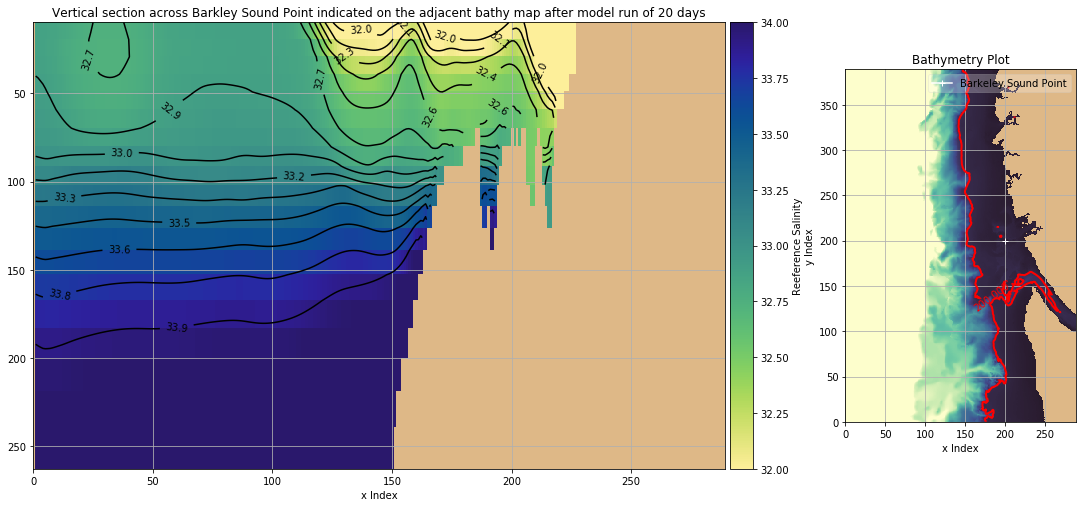

In [46]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 479 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 20 days')

### What do we see from the initial conditions ?

In [13]:
tracers = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_high_resolution_wide_bdy.nc')

bathy = '/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc'

bathymetry = nc.Dataset(bathy).variables['Bathymetry'][:]

lat = tracers.variables['nav_lat']
lon = tracers.variables['nav_lon']
sal = tracers.variables['vosaline']
zlevels = tracers.variables['deptht']

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


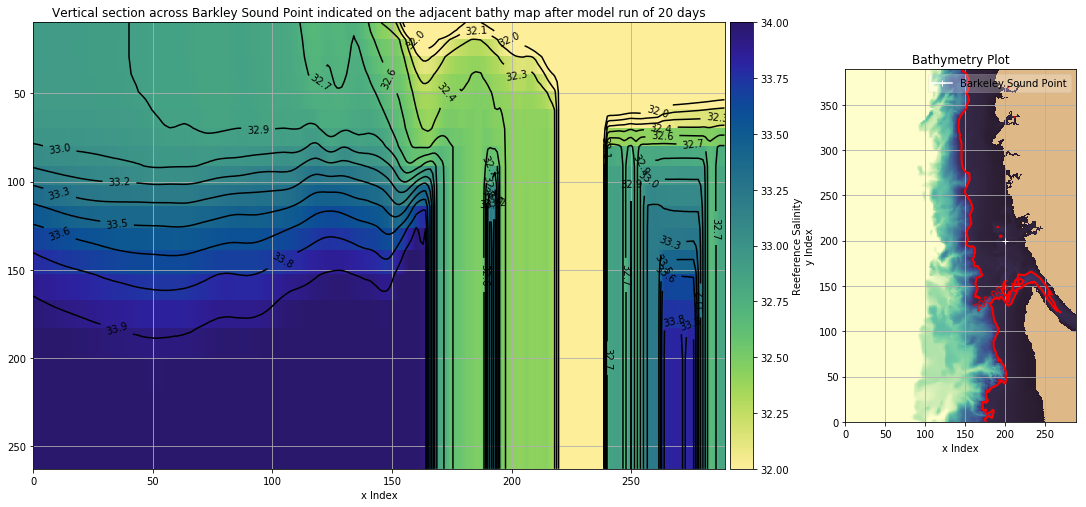

In [16]:
y_slice = np.arange(lat.shape[0])
x_slice = np.arange(lat.shape[1])


# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, bathymetry, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,bathymetry, levels = [200], colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 0
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 20 days')